### 0. Import packages

In [1]:
import logging
import missingno as msno
import numpy as np
import pandas as pd
import warnings

from pandarallel import pandarallel
from pathlib import Path
from pprint import pprint
from src.data import load_dataset
from src.features import build_features, preprocessing
from tqdm import tqdm

pandarallel.initialize()
tqdm.pandas()
warnings.filterwarnings("ignore")

/usr/local/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


### 1. Load datasets

In [2]:
# global variables
DATA_PATH = Path('data/interim/')
CATEGORY = 'Clothing_Shoes_and_Jewelry'

In [3]:
%%time
prod_reviews = load_dataset.load_dataset(CATEGORY, DATA_PATH, load_meta=False)

CPU times: user 1.66 s, sys: 212 ms, total: 1.87 s
Wall time: 1.9 s


In [4]:
print(prod_reviews.info(memory_usage="deep"))
prod_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278677 entries, 0 to 278676
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     278677 non-null  float64
 1   reviewerID  278677 non-null  object 
 2   asin        278677 non-null  object 
 3   reviewText  278653 non-null  object 
dtypes: float64(1), object(3)
memory usage: 137.7 MB
None


,overall,reviewerID,asin,reviewText
0,5.0,A1KLRMWW2FWPL4,0000031887,This is a great tutu and at a really great pri...
1,5.0,A2G5TCU2WDFZ65,0000031887,I bought this for my 4 yr old daughter for dan...
2,5.0,A1RLQXYNCMWRWN,0000031887,What can I say... my daughters have it in oran...
3,5.0,A8U3FAMSJVHS5,0000031887,"We bought several tutus at once, and they are ..."
4,5.0,A3GEOILWLK86XM,0000031887,Thank you Halo Heaven great product for Little...


In [5]:
# print(prod_meta.info(memory_usage="deep"))
# prod_meta.head()

In [6]:
# # merge reviews and metadata
# prod_merged = pd.merge(prod_reviews, prod_meta, how='inner', on='asin')

# print(prod_merged.info(memory_usage="deep"))
# prod_merged.head()

In [7]:
# temp solution to prevent major code change
prod_merged = prod_reviews

<AxesSubplot:>

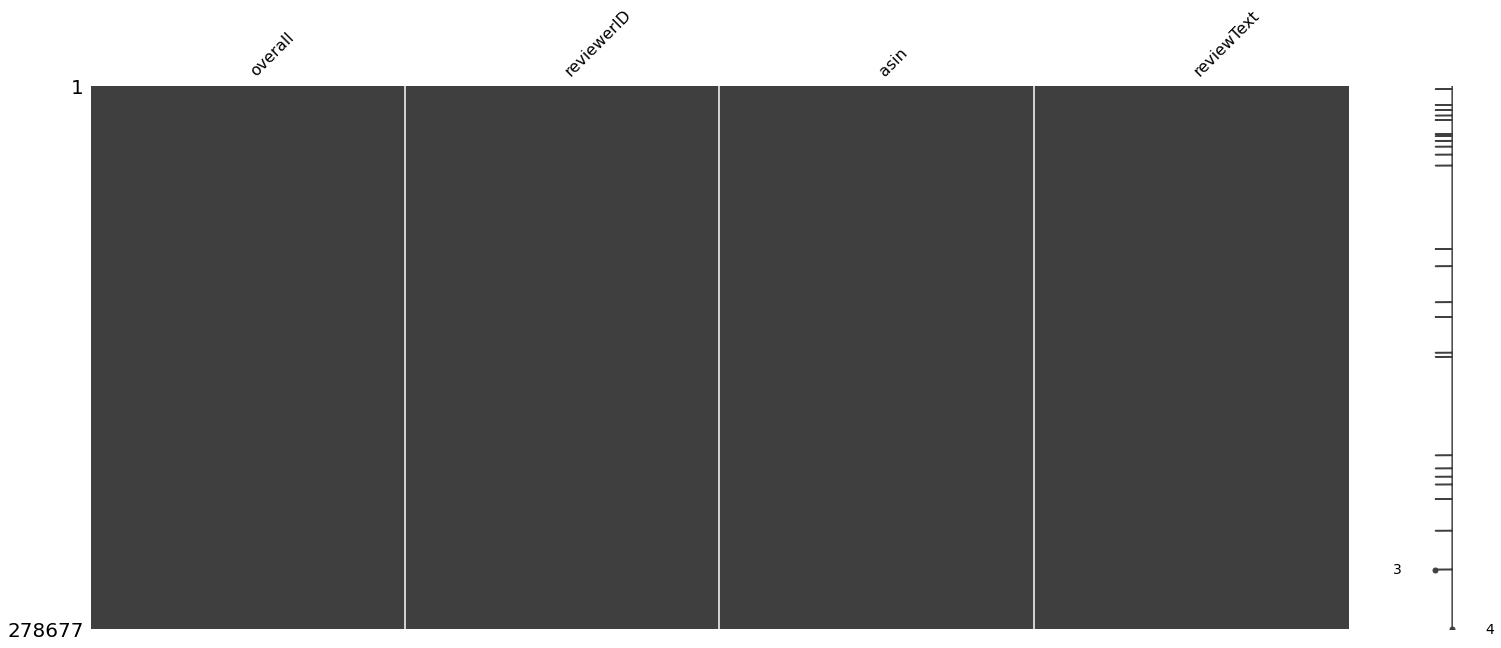

In [8]:
# visualise the null compositions
msno.matrix(prod_merged)

In [9]:
# first attempt at removing possible null values disguised as other value
prod_merged = prod_merged.replace({'': np.nan})
# drop all in empty values in either overall, reviewText, titl
prod_merged = prod_merged.dropna(subset=['asin', 'overall', 'reviewText'], axis=0)
# drop duplicated reviews due to different item variant
prod_merged = prod_merged.drop_duplicates(subset=['asin', 'overall', 'reviewerID','reviewText'], keep='first')

print(prod_merged.info(memory_usage="deep"))
prod_merged.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278653 entries, 0 to 278676
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   overall     278653 non-null  float64
 1   reviewerID  278653 non-null  object 
 2   asin        278653 non-null  object 
 3   reviewText  278653 non-null  object 
dtypes: float64(1), object(3)
memory usage: 139.8 MB
None


,overall,reviewerID,asin,reviewText
0,5.0,A1KLRMWW2FWPL4,0000031887,This is a great tutu and at a really great pri...
1,5.0,A2G5TCU2WDFZ65,0000031887,I bought this for my 4 yr old daughter for dan...
2,5.0,A1RLQXYNCMWRWN,0000031887,What can I say... my daughters have it in oran...
3,5.0,A8U3FAMSJVHS5,0000031887,"We bought several tutus at once, and they are ..."
4,5.0,A3GEOILWLK86XM,0000031887,Thank you Halo Heaven great product for Little...


### 2. Conduct text processing

In [10]:
%%time
prod_merged['processedReviewText'] = prod_merged['reviewText'].parallel_apply(build_features.text_preprocess)

CPU times: user 2.38 s, sys: 715 ms, total: 3.09 s
Wall time: 3min 31s


In [11]:
# conduct second round of null value removal
prod_merged = preprocessing.removing_missing_reviews(prod_merged, 'processedReviewText')
prod_merged.reset_index(inplace=True)

100%|██████████| 278653/278653 [00:00<00:00, 419018.83it/s]


In [12]:
print(prod_merged.shape)
prod_merged.head().append(prod_merged.tail())

(278636, 6)


,index,overall,reviewerID,asin,reviewText,processedReviewText
0,0,5.0,A1KLRMWW2FWPL4,0000031887,This is a great tutu and at a really great pri...,this great tutu great price it look cheap glad...
1,1,5.0,A2G5TCU2WDFZ65,0000031887,I bought this for my 4 yr old daughter for dan...,buy yr old daughter dance class wore today tim...
2,2,5.0,A1RLQXYNCMWRWN,0000031887,What can I say... my daughters have it in oran...,what daughters orange black white pink think b...
3,3,5.0,A8U3FAMSJVHS5,0000031887,"We bought several tutus at once, and they are ...",we buy tutu get high review sturdy seemingly t...
4,4,5.0,A3GEOILWLK86XM,0000031887,Thank you Halo Heaven great product for Little...,thank halo heaven great product little girls m...
278631,278631,5.0,A2DG63DN704LOI,B00KKXCJQU,I don't normally go ga-ga over a product very ...,normally ga ga product cub awesome help review...
278632,278632,5.0,A1EVV74UQYVKRY,B00KKXCJQU,I've been traveling back and forth to England ...,travel forth england pack way suitcases some p...
278633,278633,5.0,A1UQBFCERIP7VJ,B00KKXCJQU,These are very nice packing cubes and the 18 x...,these nice packing cube laundry storage bag ni...
278634,278634,5.0,A22CW0ZHY3NJH8,B00KKXCJQU,I am on vacation with my family of four and th...,vacation family shacke pak set wonderful excep...
278635,278635,5.0,A30VWT3R25QAVD,B00KKXCJQU,When I signed up to receive a free set of Shac...,when sign receive free set shacke pak review t...


### 3. Creating `HDFStore` to store our intermediary dataframe

In [13]:
# # create storage object with filename 'processed_overall'
# data_store = pd.HDFStore(f"{DATA_PATH/'processed_overall.h5'}")

# # put dataframe into the object setting the key as 'movie_overall_processed'
# data_store[CATEGORY] = prod_merged
# data_store.close()

In [14]:
%%time
# temporary store as pkl
prod_merged.to_pickle(f"{DATA_PATH}/{CATEGORY}_processed.pkl")

CPU times: user 201 ms, sys: 61.1 ms, total: 263 ms
Wall time: 287 ms


In [15]:
%%time
# loading processed dataframe from pkl
prod_merged = pd.read_pickle(f"{DATA_PATH}/{CATEGORY}_processed.pkl")

CPU times: user 169 ms, sys: 62.2 ms, total: 231 ms
Wall time: 233 ms


In [16]:
print(prod_merged.shape)
prod_merged.head().append(prod_merged.tail())

(278636, 6)


,index,overall,reviewerID,asin,reviewText,processedReviewText
0,0,5.0,A1KLRMWW2FWPL4,0000031887,This is a great tutu and at a really great pri...,this great tutu great price it look cheap glad...
1,1,5.0,A2G5TCU2WDFZ65,0000031887,I bought this for my 4 yr old daughter for dan...,buy yr old daughter dance class wore today tim...
2,2,5.0,A1RLQXYNCMWRWN,0000031887,What can I say... my daughters have it in oran...,what daughters orange black white pink think b...
3,3,5.0,A8U3FAMSJVHS5,0000031887,"We bought several tutus at once, and they are ...",we buy tutu get high review sturdy seemingly t...
4,4,5.0,A3GEOILWLK86XM,0000031887,Thank you Halo Heaven great product for Little...,thank halo heaven great product little girls m...
278631,278631,5.0,A2DG63DN704LOI,B00KKXCJQU,I don't normally go ga-ga over a product very ...,normally ga ga product cub awesome help review...
278632,278632,5.0,A1EVV74UQYVKRY,B00KKXCJQU,I've been traveling back and forth to England ...,travel forth england pack way suitcases some p...
278633,278633,5.0,A1UQBFCERIP7VJ,B00KKXCJQU,These are very nice packing cubes and the 18 x...,these nice packing cube laundry storage bag ni...
278634,278634,5.0,A22CW0ZHY3NJH8,B00KKXCJQU,I am on vacation with my family of four and th...,vacation family shacke pak set wonderful excep...
278635,278635,5.0,A30VWT3R25QAVD,B00KKXCJQU,When I signed up to receive a free set of Shac...,when sign receive free set shacke pak review t...


### 4. Generating train/test split

In [17]:
def train_test_split(df, sample_rate):
    # generating user-review mapping
    user_review_map = df.groupby(["reviewerID"])["index"].progress_apply(list).to_dict()

    test_review_index = set()
    for user in user_review_map:
        sample_number = int(len(user_review_map[user]) * sample_rate)
        test_review_index |= set(
            np.random.choice(user_review_map[user], sample_number, replace=False)
        )

    train = df[~df["index"].isin(test_review_index)]
    test = df[df["index"].isin(test_review_index)]

    # removing any user/items that is in test but NOT in train
    train_prods = train["asin"].unique()
    train_users = train["reviewerID"].unique()

    test = test[
        (test["asin"].isin(train_prods)) & (test["reviewerID"].isin(train_users))
    ]

    # drop existing `index` column and reset index
    train, test = train.drop(["index"], axis=1), test.drop(["index"], axis=1)

    return train, test

In [18]:
train, test = train_test_split(prod_merged, .2)

100%|██████████| 39387/39387 [00:01<00:00, 37414.39it/s]


#### Checking train/test dataset

In [19]:
print(train.shape)
train.head().append(train.tail())

(231491, 5)


,overall,reviewerID,asin,reviewText,processedReviewText
0,5.0,A1KLRMWW2FWPL4,0000031887,This is a great tutu and at a really great pri...,this great tutu great price it look cheap glad...
1,5.0,A2G5TCU2WDFZ65,0000031887,I bought this for my 4 yr old daughter for dan...,buy yr old daughter dance class wore today tim...
2,5.0,A1RLQXYNCMWRWN,0000031887,What can I say... my daughters have it in oran...,what daughters orange black white pink think b...
5,4.0,A27UF1MSF3DB2,0000031887,I received this today and I'm not a fan of it ...,receive today fan daughter think puffier look ...
6,5.0,A16GFPNVF4Y816,0000031887,Bought this as a backup to the regular ballet ...,bought backup regular ballet outfit daughter w...
278630,5.0,ACJT8MUC0LRF0,B00KKXCJQU,When I pack it looks like a disaster area in a...,when pack look like disaster area suitcase pac...
278631,5.0,A2DG63DN704LOI,B00KKXCJQU,I don't normally go ga-ga over a product very ...,normally ga ga product cub awesome help review...
278633,5.0,A1UQBFCERIP7VJ,B00KKXCJQU,These are very nice packing cubes and the 18 x...,these nice packing cube laundry storage bag ni...
278634,5.0,A22CW0ZHY3NJH8,B00KKXCJQU,I am on vacation with my family of four and th...,vacation family shacke pak set wonderful excep...
278635,5.0,A30VWT3R25QAVD,B00KKXCJQU,When I signed up to receive a free set of Shac...,when sign receive free set shacke pak review t...


In [20]:
print(f"For train set, unique users: {train['reviewerID'].nunique()}, unique items: {train['asin'].nunique()}") 

For train set, unique users: 39387, unique items: 23033


In [21]:
print(test.shape)
test.head().append(test.tail())

(47145, 5)


,overall,reviewerID,asin,reviewText,processedReviewText
3,5.0,A8U3FAMSJVHS5,0000031887,"We bought several tutus at once, and they are ...",we buy tutu get high review sturdy seemingly t...
4,5.0,A3GEOILWLK86XM,0000031887,Thank you Halo Heaven great product for Little...,thank halo heaven great product little girls m...
11,5.0,A2A2WZYLU528RO,0000031887,My daughter has worn this skirt almost every d...,my daughter worn skirt day receive washer clot...
13,5.0,A34ATJR9KFIXL9,0000031887,Full and well stitched. This tutu is a beauti...,full stitch this tutu beautiful purple color l...
16,5.0,A1MXJVYXE2QU6H,0000031887,Perfect for my budding grand daughter ballerin...,perfect bud grand daughter ballerina beautiful...
278619,5.0,A2XX2A4OJCDNLZ,B00KF9180W,While balaclavas can be used for a variety of ...,while balaclavas variety thing use mainly late...
278622,2.0,A34BZM6S9L7QI4,B00KGCLROK,These were a free sample for review. I was ex...,these free sample review excite try unfortunat...
278624,5.0,A25C2M3QF9G7OQ,B00KGCLROK,These socks are very nicely made and quite com...,these sock nicely comfortable wear the grip do...
278629,5.0,AEL6CQNQXONBX,B00KKXCJQU,This set of travel organizers includes four pi...,this set travel organizer include piece total ...
278632,5.0,A1EVV74UQYVKRY,B00KKXCJQU,I've been traveling back and forth to England ...,travel forth england pack way suitcases some p...


In [22]:
print(f"For test set, unique users: {test['reviewerID'].nunique()}, unique items: {test['asin'].nunique()}") 

For test set, unique users: 39380, unique items: 17949


#### Saving train/test data to `data/processed/`

In [23]:
DATA_PATH = Path("data/processed/")

train.to_csv(f"{DATA_PATH}/{CATEGORY}_train.csv", index=False)
test.to_csv(f"{DATA_PATH}/{CATEGORY}_test.csv", index=False)